In [82]:
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
#from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
import seaborn as sns
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql.functions import lit, desc, col, size, array_contains, isnan, count,when,udf, hour, array_min, array_max, countDistinct
from pyspark.sql.functions import *
from pyspark.sql.types import *


In [83]:

#Running a local SparkSession
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

## Schema for the spark dataframe

In [84]:
schema = StructType([
    StructField("srcip",StringType(),True),
    StructField("sport",IntegerType(),True),
    StructField("dstip",StringType(),True),
    StructField("dsport",IntegerType(),True),
    StructField("proto",StringType(),True),
    StructField("state",StringType(),True),
    StructField("dur",DoubleType(),True),
    StructField("sbytes",IntegerType(),True),
    StructField("dbytes",IntegerType(),True),
    StructField("sttl",IntegerType(),True),
    StructField("dttl",IntegerType(),True),
    StructField("sloss",IntegerType(),True),
    StructField("dloss",IntegerType(),True),
    StructField("service",StringType(),True),
    StructField("sload",FloatType(),True),
    StructField("dload",FloatType(),True),
    StructField("Spkts",IntegerType(),True),
    StructField("Dpkts",IntegerType(),True),
    StructField("swin",IntegerType(),True),
    StructField("dwin",IntegerType(),True),
    StructField("stcpb",IntegerType(),True),
    StructField("dtcpb",IntegerType(),True),
    StructField("smeanssz",IntegerType(),True),
    StructField("dmeansz",IntegerType(),True),
    StructField("trans_depth",IntegerType(),True),
    StructField("res_bdy_len",IntegerType(),True),
    StructField("Sjit",FloatType(),True),
    StructField("Djit",FloatType(),True),
    StructField("Stime",StringType(),True),
    StructField("Ltime",StringType(),True),
    StructField("Sintpkt",FloatType(),True),
    StructField("Dintpkt",FloatType(),True),
    StructField("tcprtt",FloatType(),True),
    StructField("synack",FloatType(),True),
    StructField("ackdat",FloatType(),True),
    StructField("is_sm_ips_ports",IntegerType(),True),
    StructField("ct_state_ttl",IntegerType(),True),
    StructField("ct_flw_http_mthd",IntegerType(),True),
    StructField("is_ftp_login",IntegerType(),True),
    StructField("ct_ftp_cmd",IntegerType(),True),
    StructField("ct_srv_src",IntegerType(),True),
    StructField("ct_srv_dst",IntegerType(),True),
    StructField("ct_dst_ltm",IntegerType(),True),
    StructField("ct_src_ltm",IntegerType(),True),
    StructField("ct_src_dport_ltm",IntegerType(),True),
    StructField("ct_dst_sport_ltm",IntegerType(),True),
    StructField("ct_dst_src_ltm",IntegerType(),True),
    StructField("attack_cat",StringType(),True),
    StructField("Label",IntegerType(),True)
  ]
)
spark.conf.set("spark.sql.debug.maxToStringFields", 1000)

## Read the Csv from HDFS

In [142]:
ds_path='hdfs://localhost:9000/DataAnalysis/UNSW-NB15.csv'
df = spark.read.load(ds_path,format="csv", inferSchema="False",schema=schema)

## Displaying the first 3 rows before any processing and tranformation

In [41]:
df.show(3)

+----------+-----+-------------+------+-----+-----+--------+------+------+----+----+-----+-----+-------+---------+---------+-----+-----+----+----+-----+-----+--------+-------+-----------+-----------+-------+---------+----------+----------+-------+--------+------+------+------+---------------+------------+----------------+------------+----------+----------+----------+----------+----------+----------------+----------------+--------------+----------+-----+
|     srcip|sport|        dstip|dsport|proto|state|     dur|sbytes|dbytes|sttl|dttl|sloss|dloss|service|    sload|    dload|Spkts|Dpkts|swin|dwin|stcpb|dtcpb|smeanssz|dmeansz|trans_depth|res_bdy_len|   Sjit|     Djit|     Stime|     Ltime|Sintpkt| Dintpkt|tcprtt|synack|ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|Label|
+----------+-----+-------------+------+-----+-----+--------+------+------+----+----+

## Schema display

In [6]:
df.printSchema()

root
 |-- srcip: string (nullable = true)
 |-- sport: integer (nullable = true)
 |-- dstip: string (nullable = true)
 |-- dsport: integer (nullable = true)
 |-- proto: string (nullable = true)
 |-- state: string (nullable = true)
 |-- dur: double (nullable = true)
 |-- sbytes: integer (nullable = true)
 |-- dbytes: integer (nullable = true)
 |-- sttl: integer (nullable = true)
 |-- dttl: integer (nullable = true)
 |-- sloss: integer (nullable = true)
 |-- dloss: integer (nullable = true)
 |-- service: string (nullable = true)
 |-- sload: float (nullable = true)
 |-- dload: float (nullable = true)
 |-- Spkts: integer (nullable = true)
 |-- Dpkts: integer (nullable = true)
 |-- swin: integer (nullable = true)
 |-- dwin: integer (nullable = true)
 |-- stcpb: integer (nullable = true)
 |-- dtcpb: integer (nullable = true)
 |-- smeanssz: integer (nullable = true)
 |-- dmeansz: integer (nullable = true)
 |-- trans_depth: integer (nullable = true)
 |-- res_bdy_len: integer (nullable = true)
 

## pyspark DF dimension

In [7]:
shape = (df.count(), len(df.columns))
shape

(2540047, 49)

## check if there is any Null or missing values

In [8]:

df2 = df.select([count(when(col(c).contains('None') , c \
                           )).alias(c) for c in df.columns])

In [9]:
df2.show()

+-----+-----+-----+------+-----+-----+---+------+------+----+----+-----+-----+-------+-----+-----+-----+-----+----+----+-----+-----+--------+-------+-----------+-----------+----+----+-----+-----+-------+-------+------+------+------+---------------+------------+----------------+------------+----------+----------+----------+----------+----------+----------------+----------------+--------------+----------+-----+
|srcip|sport|dstip|dsport|proto|state|dur|sbytes|dbytes|sttl|dttl|sloss|dloss|service|sload|dload|Spkts|Dpkts|swin|dwin|stcpb|dtcpb|smeanssz|dmeansz|trans_depth|res_bdy_len|Sjit|Djit|Stime|Ltime|Sintpkt|Dintpkt|tcprtt|synack|ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|Label|
+-----+-----+-----+------+-----+-----+---+------+------+----+----+-----+-----+-------+-----+-----+-----+-----+----+----+-----+-----+--------+-------+-----------+-----------+-

In [10]:
df3 = df.select([count(when(col(c).contains('NULL') , c \
                           )).alias(c) for c in df.columns])
df3.show()

+-----+-----+-----+------+-----+-----+---+------+------+----+----+-----+-----+-------+-----+-----+-----+-----+----+----+-----+-----+--------+-------+-----------+-----------+----+----+-----+-----+-------+-------+------+------+------+---------------+------------+----------------+------------+----------+----------+----------+----------+----------+----------------+----------------+--------------+----------+-----+
|srcip|sport|dstip|dsport|proto|state|dur|sbytes|dbytes|sttl|dttl|sloss|dloss|service|sload|dload|Spkts|Dpkts|swin|dwin|stcpb|dtcpb|smeanssz|dmeansz|trans_depth|res_bdy_len|Sjit|Djit|Stime|Ltime|Sintpkt|Dintpkt|tcprtt|synack|ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|Label|
+-----+-----+-----+------+-----+-----+---+------+------+----+----+-----+-----+-------+-----+-----+-----+-----+----+----+-----+-----+--------+-------+-----------+-----------+-

In [11]:
df4 = df.select([count(when((col(c) == '-' ) , c \
                           )).alias(c) for c in df.columns])
df4.show()

+-----+-----+-----+------+-----+-----+---+------+------+----+----+-----+-----+-------+-----+-----+-----+-----+----+----+-----+-----+--------+-------+-----------+-----------+----+----+-----+-----+-------+-------+------+------+------+---------------+------------+----------------+------------+----------+----------+----------+----------+----------+----------------+----------------+--------------+----------+-----+
|srcip|sport|dstip|dsport|proto|state|dur|sbytes|dbytes|sttl|dttl|sloss|dloss|service|sload|dload|Spkts|Dpkts|swin|dwin|stcpb|dtcpb|smeanssz|dmeansz|trans_depth|res_bdy_len|Sjit|Djit|Stime|Ltime|Sintpkt|Dintpkt|tcprtt|synack|ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|Label|
+-----+-----+-----+------+-----+-----+---+------+------+----+----+-----+-----+-------+-----+-----+-----+-----+----+----+-----+-----+--------+-------+-----------+-----------+-

### from the results above, we can see that column 'service' has 1246397 rows that contains '-', we will change '-' to None

In [143]:
df =df.na.replace('-', None)
df4 = df.select([count(when((col(c) == '-' ) , c \
                           )).alias(c) for c in df.columns])
df4.show()

+-----+-----+-----+------+-----+-----+---+------+------+----+----+-----+-----+-------+-----+-----+-----+-----+----+----+-----+-----+--------+-------+-----------+-----------+----+----+-----+-----+-------+-------+------+------+------+---------------+------------+----------------+------------+----------+----------+----------+----------+----------+----------------+----------------+--------------+----------+-----+
|srcip|sport|dstip|dsport|proto|state|dur|sbytes|dbytes|sttl|dttl|sloss|dloss|service|sload|dload|Spkts|Dpkts|swin|dwin|stcpb|dtcpb|smeanssz|dmeansz|trans_depth|res_bdy_len|Sjit|Djit|Stime|Ltime|Sintpkt|Dintpkt|tcprtt|synack|ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|Label|
+-----+-----+-----+------+-----+-----+---+------+------+----+----+-----+-----+-------+-----+-----+-----+-----+----+----+-----+-----+--------+-------+-----------+-----------+-

In [13]:
df5 = df.select([count(when(col(c).isNull() | \
                           isnan(c), c 
                           )).alias(c) for c in df.columns])
df5.show()

+-----+-----+-----+------+-----+-----+---+------+------+----+----+-----+-----+-------+-----+-----+-----+-----+----+----+------+------+--------+-------+-----------+-----------+----+----+-----+-----+-------+-------+------+------+------+---------------+------------+----------------+------------+----------+----------+----------+----------+----------+----------------+----------------+--------------+----------+-----+
|srcip|sport|dstip|dsport|proto|state|dur|sbytes|dbytes|sttl|dttl|sloss|dloss|service|sload|dload|Spkts|Dpkts|swin|dwin| stcpb| dtcpb|smeanssz|dmeansz|trans_depth|res_bdy_len|Sjit|Djit|Stime|Ltime|Sintpkt|Dintpkt|tcprtt|synack|ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|Label|
+-----+-----+-----+------+-----+-----+---+------+------+----+----+-----+-----+-------+-----+-----+-----+-----+----+----+------+------+--------+-------+-----------+-------

### from the result above, we can see that many columns has null values, we will change these null values to 0 and check again

In [144]:
df= df.na.fill(0)
#df =df.na.replace('Null', None)

In [16]:
df5 = df.select([count(when(col(c).isNull() | \
                           isnan(c), c 
                           )).alias(c) for c in df.columns])
df5.show()

+-----+-----+-----+------+-----+-----+---+------+------+----+----+-----+-----+-------+-----+-----+-----+-----+----+----+-----+-----+--------+-------+-----------+-----------+----+----+-----+-----+-------+-------+------+------+------+---------------+------------+----------------+------------+----------+----------+----------+----------+----------+----------------+----------------+--------------+----------+-----+
|srcip|sport|dstip|dsport|proto|state|dur|sbytes|dbytes|sttl|dttl|sloss|dloss|service|sload|dload|Spkts|Dpkts|swin|dwin|stcpb|dtcpb|smeanssz|dmeansz|trans_depth|res_bdy_len|Sjit|Djit|Stime|Ltime|Sintpkt|Dintpkt|tcprtt|synack|ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|Label|
+-----+-----+-----+------+-----+-----+---+------+------+----+----+-----+-----+-------+-----+-----+-----+-----+----+----+-----+-----+--------+-------+-----------+-----------+-

In [17]:
df6 = df.select([count(when((col(c) == '' ) , c \
                           )).alias(c) for c in df.columns])
df6.show()

+-----+-----+-----+------+-----+-----+---+------+------+----+----+-----+-----+-------+-----+-----+-----+-----+----+----+-----+-----+--------+-------+-----------+-----------+----+----+-----+-----+-------+-------+------+------+------+---------------+------------+----------------+------------+----------+----------+----------+----------+----------+----------------+----------------+--------------+----------+-----+
|srcip|sport|dstip|dsport|proto|state|dur|sbytes|dbytes|sttl|dttl|sloss|dloss|service|sload|dload|Spkts|Dpkts|swin|dwin|stcpb|dtcpb|smeanssz|dmeansz|trans_depth|res_bdy_len|Sjit|Djit|Stime|Ltime|Sintpkt|Dintpkt|tcprtt|synack|ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|Label|
+-----+-----+-----+------+-----+-----+---+------+------+----+----+-----+-----+-------+-----+-----+-----+-----+----+----+-----+-----+--------+-------+-----------+-----------+-

## removing blank spaces from attack_Cat

In [145]:
df= df.withColumn('attack_cat', trim(col("attack_cat")))

## checking unique values of the attack category column

In [146]:
df1.select("attack_cat").describe().show()

+-------+----------+
|summary|attack_cat|
+-------+----------+
|  count|   2540047|
|   mean|      null|
| stddev|      null|
|    min|  Analysis|
|    max|     Worms|
+-------+----------+



In [147]:
df1.select('attack_cat').distinct().collect()

[Row(attack_cat='Worms'),
 Row(attack_cat='Shellcode'),
 Row(attack_cat='Backdoors'),
 Row(attack_cat='Fuzzers'),
 Row(attack_cat='Analysis'),
 Row(attack_cat='DoS'),
 Row(attack_cat='Reconnaissance'),
 Row(attack_cat='Exploits'),
 Row(attack_cat='Normal'),
 Row(attack_cat='Generic'),
 Row(attack_cat='Backdoor')]

In [148]:
df.select('attack_cat').distinct().collect()

[Row(attack_cat='Worms'),
 Row(attack_cat='Shellcode'),
 Row(attack_cat=None),
 Row(attack_cat='Backdoors'),
 Row(attack_cat='Fuzzers'),
 Row(attack_cat='Analysis'),
 Row(attack_cat='DoS'),
 Row(attack_cat='Reconnaissance'),
 Row(attack_cat='Exploits'),
 Row(attack_cat='Generic'),
 Row(attack_cat='Backdoor')]

In [48]:
df.show()

+-----------+-----+-------------+------+-----+-----+--------+------+------+----+----+-----+-----+-------+---------+---------+-----+-----+----+----+-----+-----+--------+-------+-----------+-----------+--------+---------+----------+----------+--------+--------+------+------+------+---------------+------------+----------------+------------+----------+----------+----------+----------+----------+----------------+----------------+--------------+----------+-----+
|      srcip|sport|        dstip|dsport|proto|state|     dur|sbytes|dbytes|sttl|dttl|sloss|dloss|service|    sload|    dload|Spkts|Dpkts|swin|dwin|stcpb|dtcpb|smeanssz|dmeansz|trans_depth|res_bdy_len|    Sjit|     Djit|     Stime|     Ltime| Sintpkt| Dintpkt|tcprtt|synack|ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|Label|
+-----------+-----+-------------+------+-----+-----+--------+------+------+---

## changing Null values in attack_cat to normal

In [149]:
df = df.fillna({'attack_cat':'Normal'})
df.show()

+-----------+-----+-------------+------+-----+-----+--------+------+------+----+----+-----+-----+-------+---------+---------+-----+-----+----+----+-----+-----+--------+-------+-----------+-----------+--------+---------+----------+----------+--------+--------+------+------+------+---------------+------------+----------------+------------+----------+----------+----------+----------+----------+----------------+----------------+--------------+----------+-----+
|      srcip|sport|        dstip|dsport|proto|state|     dur|sbytes|dbytes|sttl|dttl|sloss|dloss|service|    sload|    dload|Spkts|Dpkts|swin|dwin|stcpb|dtcpb|smeanssz|dmeansz|trans_depth|res_bdy_len|    Sjit|     Djit|     Stime|     Ltime| Sintpkt| Dintpkt|tcprtt|synack|ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|Label|
+-----------+-----+-------------+------+-----+-----+--------+------+------+---

## Visualization of the dataset

In [22]:
##check the total attacks per category

In [150]:
Attack_count= df.select('attack_cat').groupby('attack_cat').agg(count('attack_cat').alias('count')).orderBy(desc('count'))

In [151]:
#Attack_count =Attack_count.na.drop()
Attack_count.show()
##or
Attack_count.collect()

+--------------+-------+
|    attack_cat|  count|
+--------------+-------+
|        Normal|2218764|
|       Generic| 215481|
|      Exploits|  44525|
|       Fuzzers|  24246|
|           DoS|  16353|
|Reconnaissance|  13987|
|      Analysis|   2677|
|      Backdoor|   1795|
|     Shellcode|   1511|
|     Backdoors|    534|
|         Worms|    174|
+--------------+-------+



[Row(attack_cat='Normal', count=2218764),
 Row(attack_cat='Generic', count=215481),
 Row(attack_cat='Exploits', count=44525),
 Row(attack_cat='Fuzzers', count=24246),
 Row(attack_cat='DoS', count=16353),
 Row(attack_cat='Reconnaissance', count=13987),
 Row(attack_cat='Analysis', count=2677),
 Row(attack_cat='Backdoor', count=1795),
 Row(attack_cat='Shellcode', count=1511),
 Row(attack_cat='Backdoors', count=534),
 Row(attack_cat='Worms', count=174)]

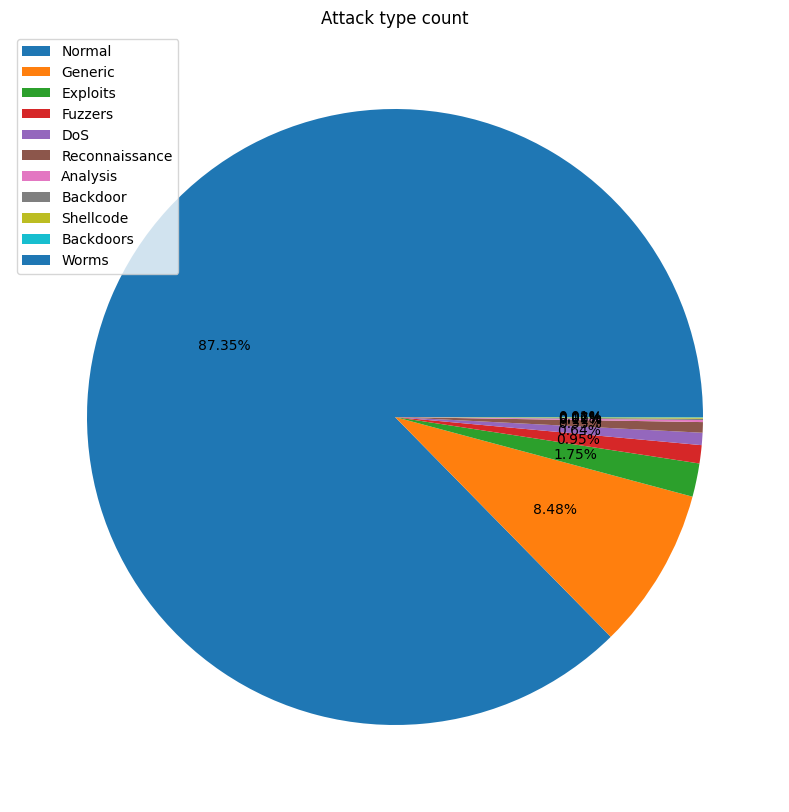

In [153]:
##plotting
l= [row['attack_cat'] for row in Attack_count.collect()]
c= [row['count'] for row in Attack_count.collect()]
plt.figure(figsize=(17,10))
#plt.xlabel('Attack type')
#plt.ylabel('Attack count')
plt.title("Attack type count")
plt.pie(c,autopct='%1.2f%%')
plt.legend(l,loc="upper left")

In [154]:
#check which Ip has the highest attack
IP_hightest=df.select('srcip').filter(df.Label ==1).groupby('srcip').agg(count('srcip').alias('count')).orderBy(desc('count'))

In [155]:
IP_hightest.show()

+------------+------+
|       srcip| count|
+------------+------+
|175.45.176.1|117908|
|175.45.176.3|106418|
|175.45.176.0| 74279|
|175.45.176.2| 22678|
+------------+------+



<BarContainer object of 4 artists>

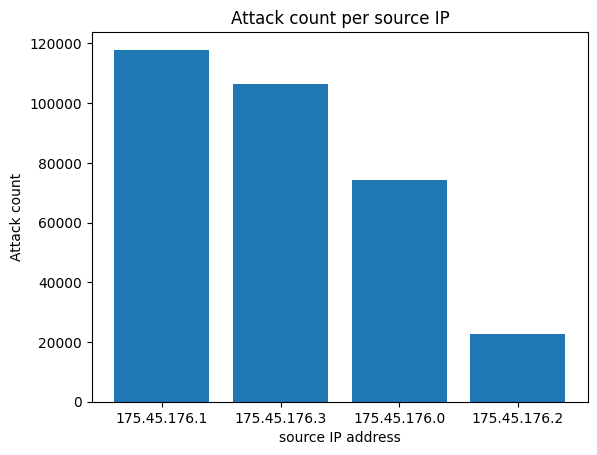

In [156]:
l1= [row['srcip'] for row in IP_hightest.collect()]
c1= [row['count'] for row in IP_hightest.collect()]
plt.xlabel('source IP address')
plt.ylabel('Attack count')
plt.title("Attack count per source IP")
plt.bar(l1,c1)

In [157]:
#check which Ip has the highest attack
sttl_df=df.select('sttl','attack_cat').filter(df.Label ==1).groupby('sttl','attack_cat').agg(count('sttl').alias('count')).orderBy(desc('count'))

<BarContainer object of 32 artists>

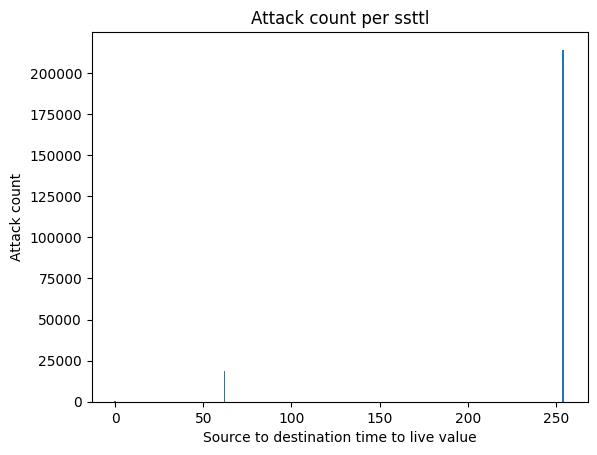

In [158]:
l1= [row['sttl'] for row in sttl_df.collect()]
c1= [row['count'] for row in sttl_df.collect()]
plt.xlabel('Source to destination time to live value')
plt.ylabel('Attack count')
plt.title("Attack count per ssttl")
plt.bar(l1,c1)

In [159]:
label_c= df.groupby("Label").count()
label_c.show()

+-----+-------+
|Label|  count|
+-----+-------+
|    1| 321283|
|    0|2218764|
+-----+-------+



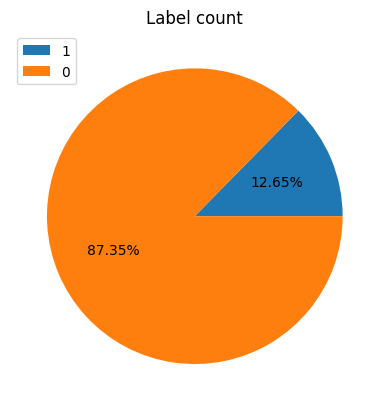

In [160]:
##plotting
l2= [row['Label'] for row in label_c.collect()]
c2= [row['count'] for row in label_c.collect()]
plt.title("Label count")
plt.pie(c2,autopct='%1.2f%%')
plt.legend(l2,loc="upper left")

# Correlation

In [89]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

In [90]:
vector_col ="corr-features"

In [91]:
assembler = VectorAssembler(inputCols=("sport","dsport","dur","sbytes","dbytes","sttl","dttl","sloss","dloss","sload","dload","Spkts","Dpkts","swin","dwin","stcpb","dtcpb","smeanssz","dmeansz","trans_depth","res_bdy_len","Sjit","Djit","Sintpkt","Dintpkt","tcprtt","synack","ackdat","is_sm_ips_ports","ct_state_ttl","ct_flw_http_mthd","is_ftp_login","ct_ftp_cmd","ct_srv_src","ct_srv_dst","ct_dst_ltm","ct_src_ltm","ct_src_dport_ltm","ct_dst_sport_ltm","ct_dst_src_ltm","Label"), outputCol=vector_col)

In [92]:
df_vector = assembler.transform(df).select(vector_col)

In [93]:
df_vector

DataFrame[corr-features: vector]

In [94]:
matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]

22/11/20 18:36:31 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/11/20 18:36:31 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


In [95]:
corrmatrix =matrix.toArray().tolist()

In [96]:
columns = ["sport","dsport","dur","sbytes","dbytes","sttl","dttl","sloss","dloss","sload","dload","Spkts","Dpkts","swin","dwin","stcpb","dtcpb","smeanssz","dmeansz","trans_depth","res_bdy_len","Sjit","Djit","Sintpkt","Dintpkt","tcprtt","synack","ackdat","is_sm_ips_ports","ct_state_ttl","ct_flw_http_mthd","is_ftp_login","ct_ftp_cmd","ct_srv_src","ct_srv_dst","ct_dst_ltm","ct_src_ltm","ct_src_dport_ltm","ct_dst_sport_ltm","ct_dst_src_ltm","Label"]

In [97]:
df_corr = spark.createDataFrame(corrmatrix, columns)

In [98]:
df_corr.select('sport','Label').show()

+--------------------+--------------------+
|               sport|               Label|
+--------------------+--------------------+
|                 1.0|-0.14984747883605454|
| 0.08669506429142189|-0.21650913297879532|
|-0.01559331658746...|0.001958997204134...|
|0.005547766998758201|0.010180321142217985|
|0.025111011994819184|-0.07554308366287153|
|-0.14943234163613325|   0.904393118271226|
| 0.10549817633491983| 0.13494719797207363|
| 0.02362886076175813|-0.04327194729532742|
|0.031878801002106945|-0.09585474232177033|
|-0.10977379663012529| 0.19227837760200162|
|0.061982157777682595|-0.21971018813220414|
|0.041740764027526675|-0.12088031292892311|
| 0.03835626237289407|-0.11594737876636446|
| 0.13927456676586958| -0.3151084609610217|
|  0.1389069162412119|-0.31391983850019944|
|0.061700187314260586| -0.1403169130153639|
| 0.06105001090545478|-0.13977969856198472|
|0.020142105005125855| -0.0653634491855474|
| 0.08993655991390473|  -0.272397044017133|
|0.028817838782632943|-0.0290406

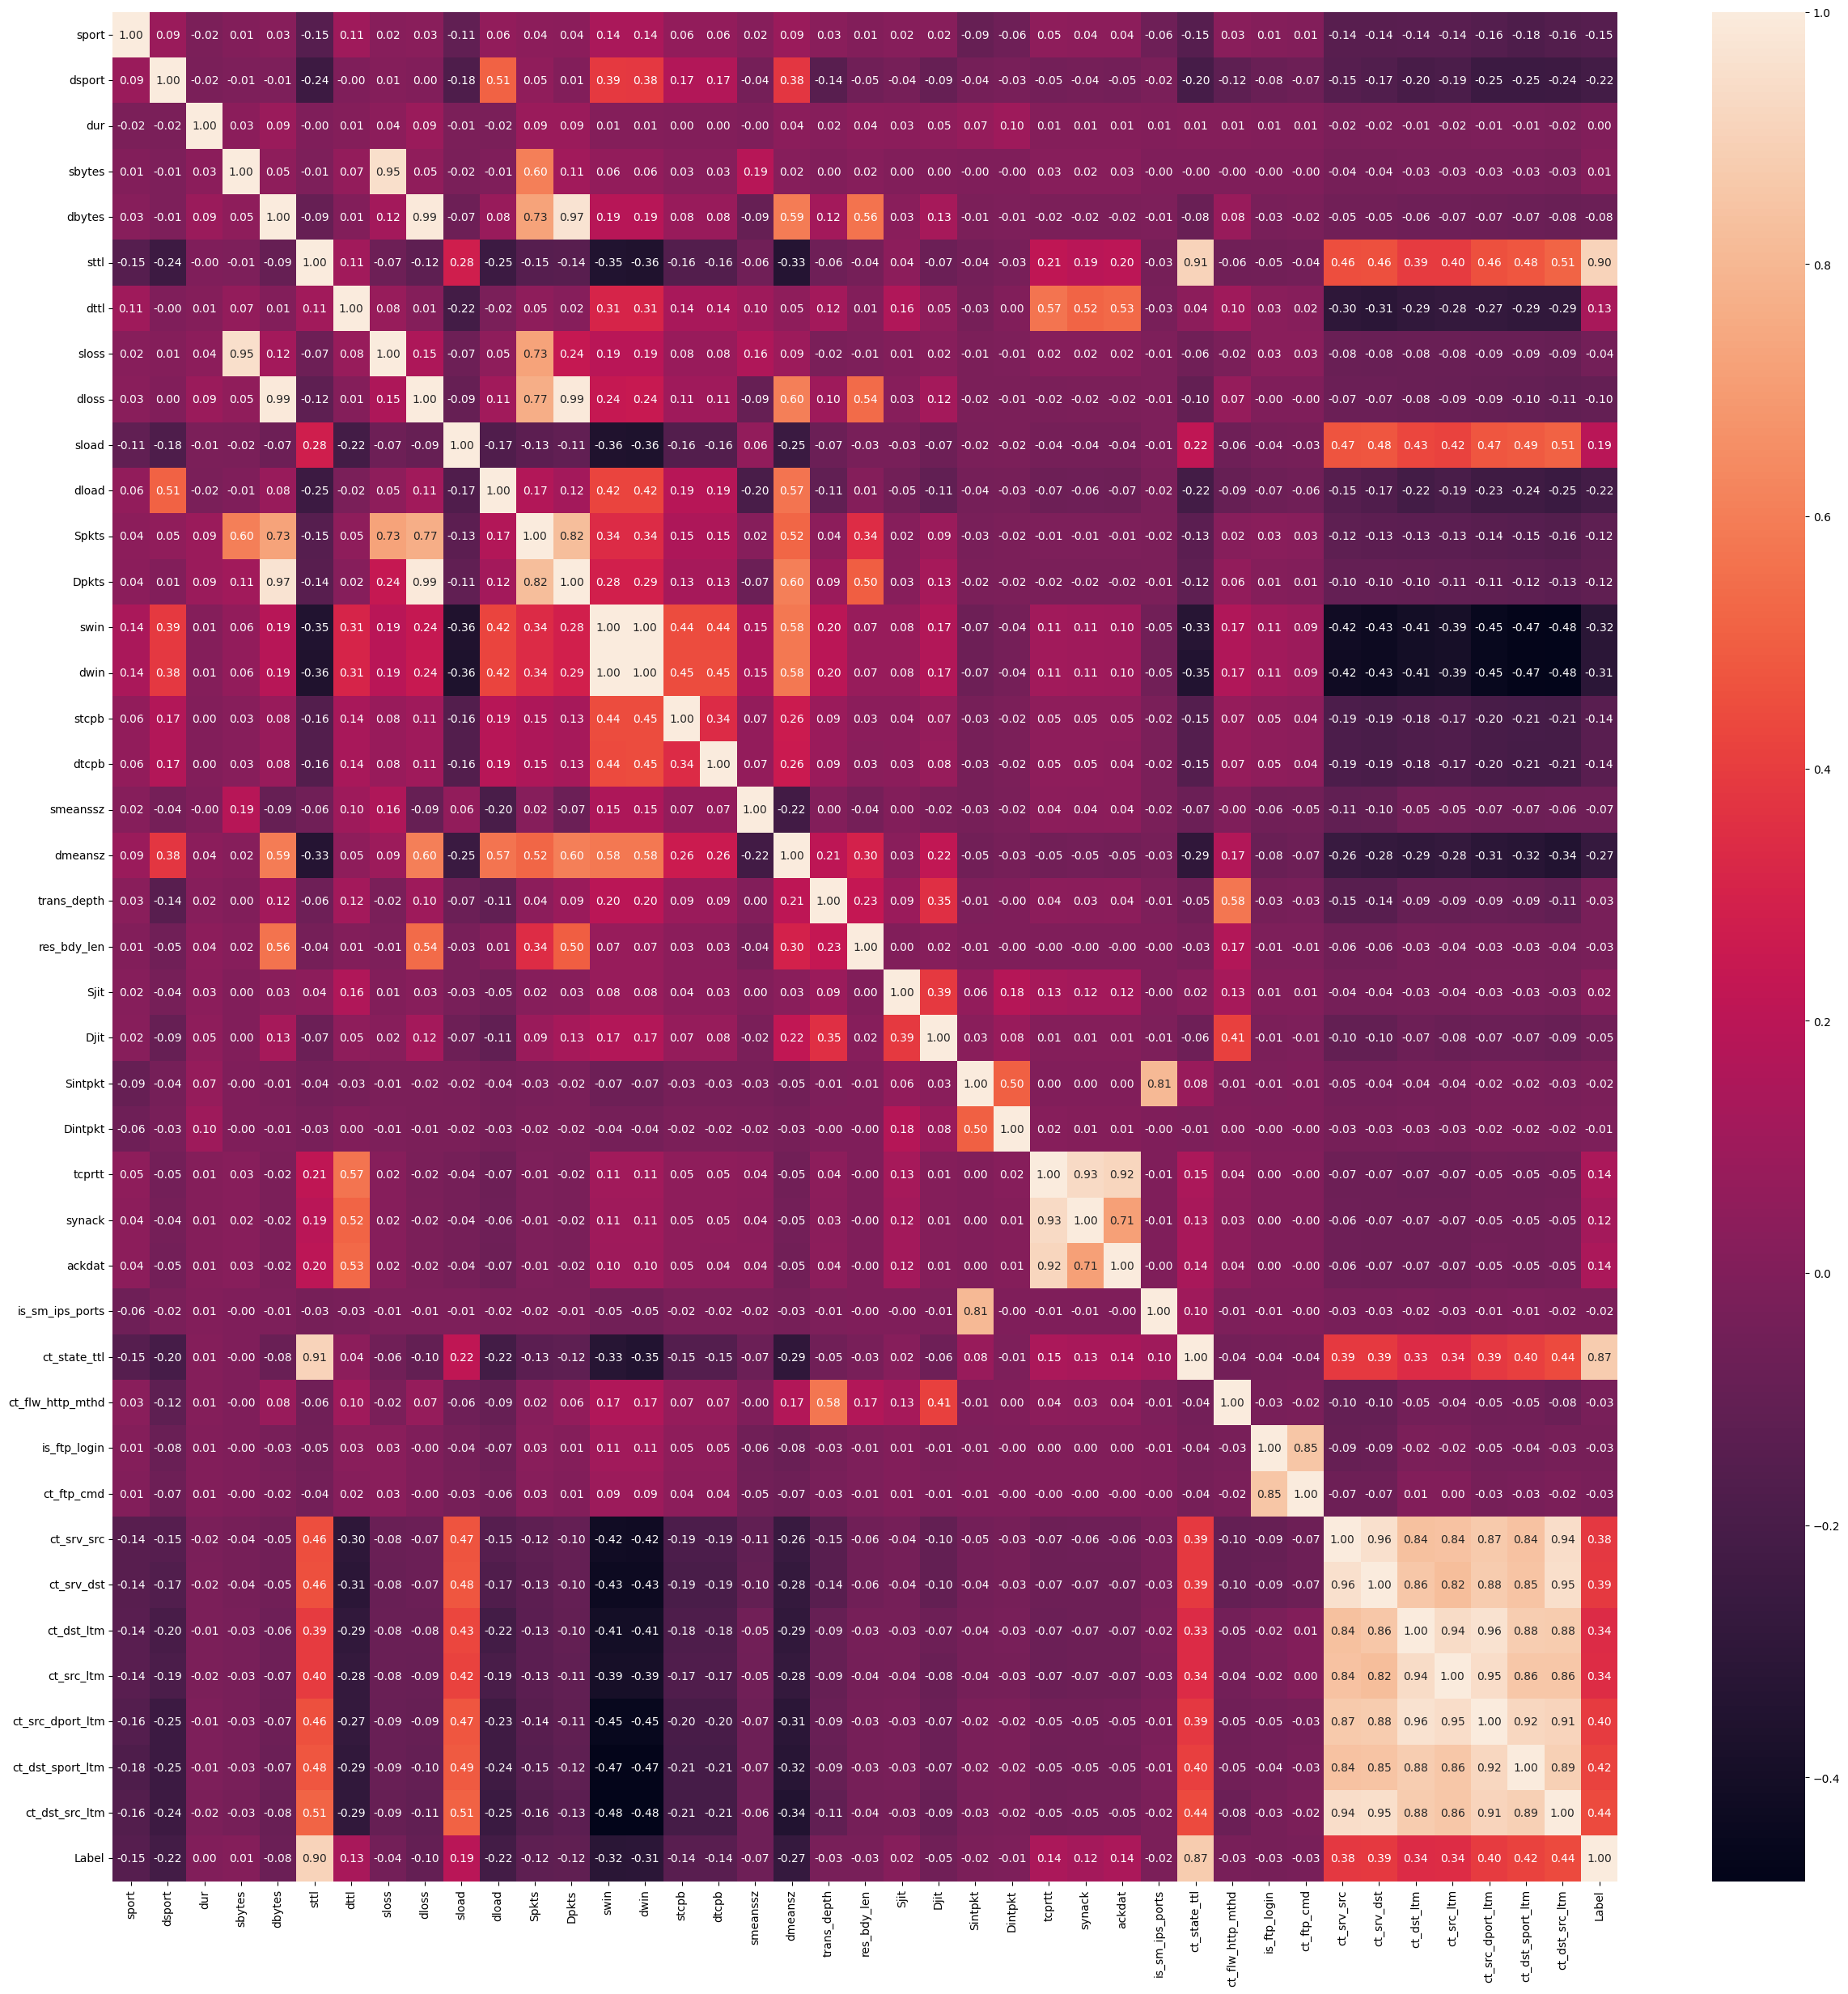

In [108]:
plt.figure(figsize = (30,30))
sns.heatmap(corrmatrix, xticklabels=df_corr.columns, yticklabels=df_corr.columns ,annot=True,fmt='.2f')
plt.show()

## Chi Square test

In [87]:

from pyspark.ml.stat import ChiSquareTest

In [108]:
assembler1= VectorAssembler(inputCols=["ct_src_ltm","ct_src_dport_ltm","ct_dst_sport_ltm","ct_dst_src_ltm"], outputCol= "vector-features")

In [109]:
df_vector1 = assembler1.transform(df).select("Label","vector-features")

In [115]:
df_vector1.show()

+-----+-----------------+
|Label|  vector-features|
+-----+-----------------+
|    0|[3.0,1.0,1.0,1.0]|
|    0|[3.0,1.0,1.0,2.0]|
|    0|[2.0,2.0,1.0,1.0]|
|    0|[1.0,1.0,1.0,1.0]|
|    0|[1.0,1.0,1.0,1.0]|
|    0|[3.0,1.0,1.0,2.0]|
|    0|[2.0,2.0,1.0,1.0]|
|    0|[2.0,2.0,2.0,2.0]|
|    0|[1.0,1.0,1.0,1.0]|
|    0|[1.0,1.0,1.0,1.0]|
|    0|[2.0,2.0,2.0,2.0]|
|    0|[2.0,2.0,2.0,2.0]|
|    0|[2.0,2.0,2.0,2.0]|
|    0|[5.0,1.0,1.0,1.0]|
|    0|[5.0,1.0,1.0,2.0]|
|    0|[5.0,1.0,1.0,2.0]|
|    0|[1.0,1.0,1.0,1.0]|
|    0|[5.0,2.0,1.0,2.0]|
|    0|[5.0,2.0,1.0,2.0]|
|    0|[1.0,1.0,1.0,1.0]|
+-----+-----------------+
only showing top 20 rows



In [135]:
results = ChiSquareTest.test(df_vector1,"vector-features", "Label")
results.show(truncate=False)

+-----------------+----------------+-------------------------------------------------------------------------+
|pValues          |degreesOfFreedom|statistics                                                               |
+-----------------+----------------+-------------------------------------------------------------------------+
|[0.0,0.0,0.0,0.0]|[61, 61, 54, 64]|[531409.3162491375,692163.8624866011,738098.8232618422,632733.1181401988]|
+-----------------+----------------+-------------------------------------------------------------------------+



## Kernel Density

22/11/20 23:24:52 ERROR Executor: Exception in task 2.0 in stage 527.0 (TID 1264)
net.razorvine.pickle.PickleException: expected zero arguments for construction of ClassDict (for pyspark.sql.types._create_row). This happens when an unsupported/unregistered class is being unpickled that requires construction arguments. Fix it by registering a custom IObjectConstructor for this class.
	at net.razorvine.pickle.objects.ClassDictConstructor.construct(ClassDictConstructor.java:23)
	at net.razorvine.pickle.Unpickler.load_reduce(Unpickler.java:759)
	at net.razorvine.pickle.Unpickler.dispatch(Unpickler.java:199)
	at net.razorvine.pickle.Unpickler.load(Unpickler.java:109)
	at net.razorvine.pickle.Unpickler.loads(Unpickler.java:122)
	at org.apache.spark.mllib.api.python.SerDeBase.$anonfun$pythonToJava$2(PythonMLLibAPI.scala:1358)
	at scala.collection.Iterator$$anon$11.nextCur(Iterator.scala:486)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:492)
	at scala.collection.Iterator.forea

Py4JJavaError: An error occurred while calling o4071.estimateKernelDensity.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 527.0 failed 1 times, most recent failure: Lost task 1.0 in stage 527.0 (TID 1263) (i-VM executor driver): net.razorvine.pickle.PickleException: expected zero arguments for construction of ClassDict (for pyspark.sql.types._create_row). This happens when an unsupported/unregistered class is being unpickled that requires construction arguments. Fix it by registering a custom IObjectConstructor for this class.
	at net.razorvine.pickle.objects.ClassDictConstructor.construct(ClassDictConstructor.java:23)
	at net.razorvine.pickle.Unpickler.load_reduce(Unpickler.java:759)
	at net.razorvine.pickle.Unpickler.dispatch(Unpickler.java:199)
	at net.razorvine.pickle.Unpickler.load(Unpickler.java:109)
	at net.razorvine.pickle.Unpickler.loads(Unpickler.java:122)
	at org.apache.spark.mllib.api.python.SerDeBase.$anonfun$pythonToJava$2(PythonMLLibAPI.scala:1358)
	at scala.collection.Iterator$$anon$11.nextCur(Iterator.scala:486)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:492)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$aggregate$2(RDD.scala:1198)
	at org.apache.spark.SparkContext.$anonfun$runJob$6(SparkContext.scala:2322)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:952)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2228)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2323)
	at org.apache.spark.rdd.RDD.$anonfun$aggregate$1(RDD.scala:1200)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.RDD.aggregate(RDD.scala:1193)
	at org.apache.spark.mllib.stat.KernelDensity.estimate(KernelDensity.scala:91)
	at org.apache.spark.mllib.api.python.PythonMLLibAPI.estimateKernelDensity(PythonMLLibAPI.scala:1077)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: net.razorvine.pickle.PickleException: expected zero arguments for construction of ClassDict (for pyspark.sql.types._create_row). This happens when an unsupported/unregistered class is being unpickled that requires construction arguments. Fix it by registering a custom IObjectConstructor for this class.
	at net.razorvine.pickle.objects.ClassDictConstructor.construct(ClassDictConstructor.java:23)
	at net.razorvine.pickle.Unpickler.load_reduce(Unpickler.java:759)
	at net.razorvine.pickle.Unpickler.dispatch(Unpickler.java:199)
	at net.razorvine.pickle.Unpickler.load(Unpickler.java:109)
	at net.razorvine.pickle.Unpickler.loads(Unpickler.java:122)
	at org.apache.spark.mllib.api.python.SerDeBase.$anonfun$pythonToJava$2(PythonMLLibAPI.scala:1358)
	at scala.collection.Iterator$$anon$11.nextCur(Iterator.scala:486)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:492)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$aggregate$2(RDD.scala:1198)
	at org.apache.spark.SparkContext.$anonfun$runJob$6(SparkContext.scala:2322)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [161]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler


In [124]:
df.printSchema()

root
 |-- srcip: string (nullable = true)
 |-- sport: integer (nullable = true)
 |-- dstip: string (nullable = true)
 |-- dsport: integer (nullable = true)
 |-- proto: string (nullable = true)
 |-- state: string (nullable = true)
 |-- dur: double (nullable = false)
 |-- sbytes: integer (nullable = true)
 |-- dbytes: integer (nullable = true)
 |-- sttl: integer (nullable = true)
 |-- dttl: integer (nullable = true)
 |-- sloss: integer (nullable = true)
 |-- dloss: integer (nullable = true)
 |-- service: string (nullable = true)
 |-- sload: float (nullable = false)
 |-- dload: float (nullable = false)
 |-- Spkts: integer (nullable = true)
 |-- Dpkts: integer (nullable = true)
 |-- swin: integer (nullable = true)
 |-- dwin: integer (nullable = true)
 |-- stcpb: integer (nullable = true)
 |-- dtcpb: integer (nullable = true)
 |-- smeanssz: integer (nullable = true)
 |-- dmeansz: integer (nullable = true)
 |-- trans_depth: integer (nullable = true)
 |-- res_bdy_len: integer (nullable = true

In [127]:
#indexed.show()

In [109]:
assembler2 = VectorAssembler(inputCols=("sport","dsport","dur","sbytes","dbytes","sttl","dttl","sloss","dloss","sload","dload","Spkts","Dpkts","swin","dwin","stcpb","dtcpb","smeanssz","dmeansz","trans_depth","res_bdy_len","Sjit","Djit","Sintpkt","Dintpkt","tcprtt","synack","ackdat","is_sm_ips_ports","ct_state_ttl","ct_flw_http_mthd","is_ftp_login","ct_ftp_cmd","ct_srv_src","ct_srv_dst","ct_dst_ltm","ct_src_ltm","ct_src_dport_ltm","ct_dst_sport_ltm","ct_dst_src_ltm"), outputCol="features")

In [162]:
assembler2

VectorAssembler_b10a86cb709a

In [163]:
output = assembler2.transform(df)

In [178]:
output.show()

+-----------+-----+-------------+------+-----+-----+--------+------+------+----+----+-----+-----+-------+---------+---------+-----+-----+----+----+-----+-----+--------+-------+-----------+-----------+--------+---------+----------+----------+--------+--------+------+------+------+---------------+------------+----------------+------------+----------+----------+----------+----------+----------+----------------+----------------+--------------+----------+-----+--------------------+
|      srcip|sport|        dstip|dsport|proto|state|     dur|sbytes|dbytes|sttl|dttl|sloss|dloss|service|    sload|    dload|Spkts|Dpkts|swin|dwin|stcpb|dtcpb|smeanssz|dmeansz|trans_depth|res_bdy_len|    Sjit|     Djit|     Stime|     Ltime| Sintpkt| Dintpkt|tcprtt|synack|ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|Label|            features|
+-----------+-----+-------------+---

In [164]:
output.select("features", "Label").show()

+--------------------+-----+
|            features|Label|
+--------------------+-----+
|(40,[0,1,2,3,4,5,...|    0|
|(40,[0,1,2,3,4,5,...|    0|
|(40,[0,1,2,3,4,5,...|    0|
|(40,[0,1,2,3,4,5,...|    0|
|(40,[0,1,2,3,4,5,...|    0|
|(40,[0,1,2,3,4,5,...|    0|
|(40,[0,1,2,3,4,5,...|    0|
|(40,[3,11,17,28,2...|    0|
|(40,[0,1,2,3,4,5,...|    0|
|(40,[0,1,2,3,4,5,...|    0|
|(40,[3,11,17,28,2...|    0|
|(40,[3,11,17,28,2...|    0|
|(40,[3,11,17,28,2...|    0|
|(40,[0,1,2,3,4,5,...|    0|
|(40,[0,1,2,3,4,5,...|    0|
|(40,[0,1,2,3,4,5,...|    0|
|(40,[0,1,2,3,4,5,...|    0|
|(40,[0,1,2,3,4,5,...|    0|
|(40,[0,1,2,3,4,5,...|    0|
|(40,[0,1,2,3,4,5,...|    0|
+--------------------+-----+
only showing top 20 rows



In [165]:
model_lr_df = output.select("features", "Label")

In [167]:
model_lr_df.filter(model_lr_df.Label == 1).show()

+--------------------+-----+
|            features|Label|
+--------------------+-----+
|(40,[0,1,2,3,5,9,...|    1|
|[23357.0,80.0,0.2...|    1|
|[13284.0,80.0,2.3...|    1|
|[13792.0,5555.0,0...|    1|
|[26939.0,80.0,0.1...|    1|
|[39500.0,80.0,0.1...|    1|
|[29309.0,3000.0,0...|    1|
|[61089.0,80.0,0.2...|    1|
|[23910.0,80.0,2.5...|    1|
|[44762.0,80.0,0.2...|    1|
|[4159.0,80.0,0.43...|    1|
|[43850.0,80.0,0.2...|    1|
|[4765.0,80.0,0.24...|    1|
|(40,[0,1,2,3,5,9,...|    1|
|[52726.0,80.0,0.5...|    1|
|[9590.0,6661.0,0....|    1|
|[36918.0,80.0,0.9...|    1|
|[27804.0,111.0,0....|    1|
|[63163.0,8080.0,0...|    1|
|[23776.0,80.0,0.1...|    1|
+--------------------+-----+
only showing top 20 rows



In [168]:
training_df, test_df = model_lr_df.randomSplit([0.7,0.3])

In [169]:
training_df.groupby("Label").count().show()

22/11/20 22:09:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/20 22:09:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/20 22:09:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/20 22:09:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/20 22:09:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/20 22:09:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/20 22:09:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/20 22:09:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+-----+-------+
|Label|  count|
+-----+-------+
|    1| 224990|
|    0|1552123|
+-----+-------+



In [170]:
print(training_df.count())

1777113


In [171]:
print(test_df.count())

762934


print(test_df.count())
test_df.groupby("Label").count().show()

# Logistic Regression

In [116]:
from pyspark.ml.classification import LogisticRegression

In [117]:
log_reg = LogisticRegression(labelCol="Label").fit(training_df)

22/11/20 19:22:45 WARN MemoryStore: Not enough space to cache rdd_385_1 in memory! (computed 113.0 MiB so far)
22/11/20 19:22:45 WARN BlockManager: Persisting block rdd_385_1 to disk instead.
22/11/20 19:22:45 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 113.0 MiB so far)
22/11/20 19:22:45 WARN BlockManager: Persisting block rdd_385_0 to disk instead.


22/11/20 19:22:59 WARN MemoryStore: Not enough space to cache rdd_385_2 in memory! (computed 33.0 MiB so far)
22/11/20 19:22:59 WARN BlockManager: Persisting block rdd_385_2 to disk instead.
22/11/20 19:23:00 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)
22/11/20 19:23:00 WARN BlockManager: Persisting block rdd_385_3 to disk instead.
22/11/20 19:23:03 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 113.0 MiB so far)


22/11/20 19:23:11 WARN MemoryStore: Not enough space to cache rdd_385_4 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:11 WARN BlockManager: Persisting block rdd_385_4 to disk instead.


22/11/20 19:23:12 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)
22/11/20 19:23:12 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)


22/11/20 19:23:14 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:14 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 65.0 MiB so far)


22/11/20 19:23:15 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:15 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:23:16 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:16 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 65.0 MiB so far)


22/11/20 19:23:17 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:17 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 65.0 MiB so far)


22/11/20 19:23:18 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:18 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:23:19 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:19 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 65.0 MiB so far)


22/11/20 19:23:20 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:20 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:23:21 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:21 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:23:21 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:22 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:23:23 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:23 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:23:24 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:24 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:23:25 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:25 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 65.0 MiB so far)


22/11/20 19:23:26 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:26 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:23:27 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:27 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:23:27 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:27 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 65.0 MiB so far)


22/11/20 19:23:28 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:29 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:23:30 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)
22/11/20 19:23:30 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)


22/11/20 19:23:31 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:31 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:23:33 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:33 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:23:34 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:34 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 65.0 MiB so far)


22/11/20 19:23:35 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:35 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 65.0 MiB so far)


22/11/20 19:23:36 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:36 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 65.0 MiB so far)


22/11/20 19:23:36 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:37 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 65.0 MiB so far)


22/11/20 19:23:37 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:37 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:23:39 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 65.0 MiB so far)
22/11/20 19:23:39 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 33.0 MiB so far)


22/11/20 19:23:39 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:39 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:23:40 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:40 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 65.0 MiB so far)


22/11/20 19:23:41 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:41 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)
22/11/20 19:23:41 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:42 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:23:42 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:42 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:23:43 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:43 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 65.0 MiB so far)


22/11/20 19:23:44 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:44 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)
22/11/20 19:23:45 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:45 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 65.0 MiB so far)


22/11/20 19:23:46 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:46 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 65.0 MiB so far)


22/11/20 19:23:46 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:46 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 65.0 MiB so far)


22/11/20 19:23:47 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:47 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:23:48 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:48 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:23:48 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:49 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:23:49 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:49 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)
22/11/20 19:23:50 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:50 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:23:51 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:51 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)
22/11/20 19:23:51 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:52 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:23:52 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:52 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:23:53 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:53 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:23:54 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:54 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:23:55 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 65.0 MiB so far)
22/11/20 19:23:55 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 33.0 MiB so far)


22/11/20 19:23:56 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:56 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:23:57 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:57 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:23:58 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:58 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)
22/11/20 19:23:59 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:23:59 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:00 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:00 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:01 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:01 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:02 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:02 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:02 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:02 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:03 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:03 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:04 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:04 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:05 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:05 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:05 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:05 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:06 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:06 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 65.0 MiB so far)
22/11/20 19:24:07 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:07 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:08 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:08 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:09 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:10 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:10 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:11 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:11 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:11 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:12 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:12 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:13 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:13 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:14 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:14 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:15 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:15 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:16 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:16 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:17 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:17 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:17 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:18 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:18 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:18 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:19 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:19 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:20 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:20 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:21 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:21 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:21 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:22 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:22 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:22 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:23 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:24 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:24 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:24 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:25 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:25 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:26 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:26 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:27 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:27 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:28 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:28 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:28 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:29 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:29 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:29 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 65.0 MiB so far)
22/11/20 19:24:30 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:30 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:31 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:31 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:32 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:32 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:33 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:33 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:33 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:34 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:34 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:35 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:35 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:35 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 65.0 MiB so far)
22/11/20 19:24:36 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:36 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:37 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:37 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:38 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:38 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:39 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:39 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:40 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:40 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:41 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)


22/11/20 19:24:41 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:42 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:42 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:43 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:43 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:44 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:44 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:45 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:45 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 65.0 MiB so far)


22/11/20 19:24:45 WARN MemoryStore: Not enough space to cache rdd_385_3 in memory! (computed 33.0 MiB so far)
22/11/20 19:24:45 WARN MemoryStore: Not enough space to cache rdd_385_0 in memory! (computed 65.0 MiB so far)


In [118]:
log_reg

LogisticRegressionModel: uid=LogisticRegression_66454c5e8543, numClasses=2, numFeatures=40

In [121]:
train_resuls = log_reg.evaluate(training_df).predictions

In [122]:
train_resuls.describe().show()

+-------+-------------------+-------------------+
|summary|              Label|         prediction|
+-------+-------------------+-------------------+
|  count|            1776761|            1776761|
|   mean|0.12649759872036814|0.13064841022512313|
| stddev|0.33240941386779105|0.33701552939854607|
|    min|                  0|                0.0|
|    max|                  1|                1.0|
+-------+-------------------+-------------------+



In [123]:
train_resuls.filter(train_resuls.Label ==1).show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|Label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(40,[0,1,2,3,4,5,...|    1|[-38.886985500284...|[1.29299480321678...|       1.0|
|(40,[0,1,2,3,4,5,...|    1|[-18.978059600973...|[5.72708245126268...|       1.0|
|(40,[0,1,2,3,4,5,...|    1|[-18.978059600973...|[5.72708245126268...|       1.0|
|(40,[0,1,2,3,4,5,...|    1|[-18.978059600973...|[5.72708245126268...|       1.0|
|(40,[0,1,2,3,4,5,...|    1|[-18.978059600973...|[5.72708245126268...|       1.0|
|(40,[0,1,2,3,4,5,...|    1|[-18.978059600973...|[5.72708245126268...|       1.0|
|(40,[0,1,2,3,4,5,...|    1|[-18.978059600973...|[5.72708245126268...|       1.0|
|(40,[0,1,2,3,4,5,...|    1|[-18.978059600973...|[5.72708245126268...|       1.0|
|(40,[0,1,2,3,4,5,...|    1|[-18.978059600973...|[5.72708245126268...|       1.0|
|(40,[0,1,2,3,4,

In [124]:
## prediction on the test data frame
results_test = log_reg.evaluate(test_df).predictions

In [193]:
results_test.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|Label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(40,[0,1,2,3,4,5,...|    0|[31.7392533795239...|[0.99999999999998...|       0.0|
|(40,[0,1,2,3,4,5,...|    0|[32.0588133172352...|[0.99999999999998...|       0.0|
|(40,[0,1,2,3,4,5,...|    0|[31.0731290824838...|[0.99999999999996...|       0.0|
|(40,[0,1,2,3,4,5,...|    0|[28.0276572485501...|[0.99999999999932...|       0.0|
|(40,[0,1,2,3,4,5,...|    0|[32.9340898336135...|[0.99999999999999...|       0.0|
|(40,[0,1,2,3,4,5,...|    0|[25.1311063320525...|[0.99999999998781...|       0.0|
|(40,[0,1,2,3,4,5,...|    0|[35.5718286080101...|[0.99999999999999...|       0.0|
|(40,[0,1,2,3,4,5,...|    0|[30.3268648596810...|[0.99999999999993...|       0.0|
|(40,[0,1,2,3,4,5,...|    0|[32.6442431740027...|[0.99999999999999...|       0.0|
|(40,[0,1,2,3,4,

In [195]:
results_test.select(["Label","prediction"]).show()

+-----+----------+
|Label|prediction|
+-----+----------+
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
+-----+----------+
only showing top 20 rows



In [125]:
# True positive

TP = results_test[(results_test.Label == 1) & (results_test.prediction ==1)].count()
TP

92624

In [126]:
# True negative
TN = results_test[(results_test.Label == 0) & (results_test.prediction ==0)].count()
TN

659715

In [174]:
#false positive
FP = results_test[(results_test.Label == 0) & (results_test.prediction ==1)].count() 
FP

7044

In [175]:
#false negative
FN = results_test[(results_test.Label == 1) & (results_test.prediction ==0)].count()
FN

3903

In [200]:
# Accuracy

In [172]:
accuracy =  float((TP + TN)/ (results_test.count()))
print("Accuracy : " + str(accuracy))

Accuracy : 0.985658062639692


In [ ]:
# Precision

In [176]:
precision = float(TP/(TP+FP))
precision

0.9293253601958502

In [177]:
# recall

In [180]:
recall = float (TP/(TP + FN))

In [181]:
print(recall)

0.9595657173640536


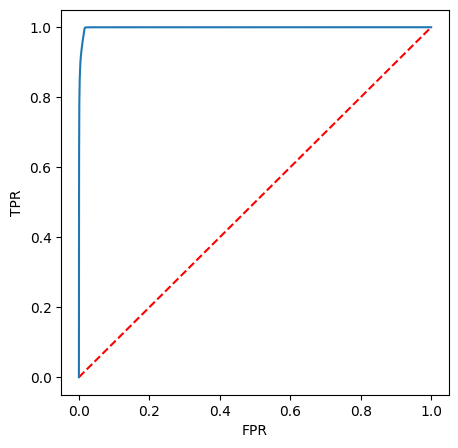

In [182]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(log_reg.summary.roc.select('FPR').collect(),
         log_reg.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

# Dicision Tree


In [184]:
df.groupBy('attack_cat').count().show()

+--------------+-------+
|    attack_cat|  count|
+--------------+-------+
|         Worms|    174|
|     Shellcode|   1511|
|     Backdoors|    534|
|       Fuzzers|  24246|
|      Analysis|   2677|
|           DoS|  16353|
|Reconnaissance|  13987|
|      Exploits|  44525|
|        Normal|2218764|
|       Generic| 215481|
|      Backdoor|   1795|
+--------------+-------+



In [185]:
assembler2

VectorAssembler_b10a86cb709a

In [186]:
output.show()

+-----------+-----+-------------+------+-----+-----+--------+------+------+----+----+-----+-----+-------+---------+---------+-----+-----+----+----+-----+-----+--------+-------+-----------+-----------+--------+---------+----------+----------+--------+--------+------+------+------+---------------+------------+----------------+------------+----------+----------+----------+----------+----------+----------------+----------------+--------------+----------+-----+--------------------+
|      srcip|sport|        dstip|dsport|proto|state|     dur|sbytes|dbytes|sttl|dttl|sloss|dloss|service|    sload|    dload|Spkts|Dpkts|swin|dwin|stcpb|dtcpb|smeanssz|dmeansz|trans_depth|res_bdy_len|    Sjit|     Djit|     Stime|     Ltime| Sintpkt| Dintpkt|tcprtt|synack|ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|Label|            features|
+-----------+-----+-------------+---

In [187]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [188]:
df_classifier = DecisionTreeClassifier(labelCol= "Label").fit(training_df)

22/11/20 22:34:10 WARN MemoryStore: Not enough space to cache rdd_880_2 in memory! (computed 12.9 MiB so far)
22/11/20 22:34:10 WARN BlockManager: Persisting block rdd_880_2 to disk instead.
22/11/20 22:34:10 WARN MemoryStore: Not enough space to cache rdd_880_3 in memory! (computed 8.5 MiB so far)
22/11/20 22:34:10 WARN BlockManager: Persisting block rdd_880_3 to disk instead.
22/11/20 22:34:15 WARN MemoryStore: Not enough space to cache rdd_880_3 in memory! (computed 47.3 MiB so far)


22/11/20 22:34:18 WARN MemoryStore: Not enough space to cache rdd_880_3 in memory! (computed 31.5 MiB so far)


22/11/20 22:34:19 WARN MemoryStore: Not enough space to cache rdd_880_3 in memory! (computed 31.5 MiB so far)


22/11/20 22:34:20 WARN MemoryStore: Not enough space to cache rdd_880_3 in memory! (computed 31.5 MiB so far)


22/11/20 22:34:22 WARN MemoryStore: Not enough space to cache rdd_880_3 in memory! (computed 31.5 MiB so far)


In [189]:
df_predictions = df_classifier.transform(test_df)

In [221]:
df_predictions.show()

+--------------------+-----+---------------+-----------+----------+
|            features|Label|  rawPrediction|probability|prediction|
+--------------------+-----+---------------+-----------+----------+
|(40,[0,1,2,3,4,5,...|    0|[1482545.0,0.0]|  [1.0,0.0]|       0.0|
|(40,[0,1,2,3,4,5,...|    0|[1482545.0,0.0]|  [1.0,0.0]|       0.0|
|(40,[0,1,2,3,4,5,...|    0|[1482545.0,0.0]|  [1.0,0.0]|       0.0|
|(40,[0,1,2,3,4,5,...|    0|[1482545.0,0.0]|  [1.0,0.0]|       0.0|
|(40,[0,1,2,3,4,5,...|    0|[1482545.0,0.0]|  [1.0,0.0]|       0.0|
|(40,[0,1,2,3,4,5,...|    0|[1482545.0,0.0]|  [1.0,0.0]|       0.0|
|(40,[0,1,2,3,4,5,...|    0|[1482545.0,0.0]|  [1.0,0.0]|       0.0|
|(40,[0,1,2,3,4,5,...|    0|[1482545.0,0.0]|  [1.0,0.0]|       0.0|
|(40,[0,1,2,3,4,5,...|    0|[1482545.0,0.0]|  [1.0,0.0]|       0.0|
|(40,[0,1,2,3,4,5,...|    0|[1482545.0,0.0]|  [1.0,0.0]|       0.0|
|(40,[0,1,2,3,4,5,...|    0|[1482545.0,0.0]|  [1.0,0.0]|       0.0|
|(40,[0,1,2,3,4,5,...|    0|[1482545.0,0.0]|  [1

In [190]:
# Accuracy
df_accuracy = MulticlassClassificationEvaluator(labelCol="Label",
                                                metricName= "accuracy").evaluate(df_predictions)

In [191]:
df_accuracy

0.9909520351694904

In [192]:
print("Test Error = %g " % (1.0 - accuracy))

Test Error = 0.0143419 


In [193]:
# precision
df_precision = MulticlassClassificationEvaluator(labelCol="Label",
                                                metricName= "weightedPrecision").evaluate(df_predictions)

In [194]:
df_precision

0.9908981008617952

In [195]:
df_recall= MulticlassClassificationEvaluator(labelCol="Label",
                                                metricName= "weightedRecall").evaluate(df_predictions)

In [196]:
df_recall

0.9909520351694905

In [197]:
df_classifier.featureImportances

SparseVector(40, {1: 0.0514, 5: 0.0011, 7: 0.0002, 9: 0.0001, 17: 0.0023, 18: 0.0066, 19: 0.0, 21: 0.0002, 28: 0.0151, 29: 0.923})

In [198]:
df_auc = MulticlassClassificationEvaluator(labelCol="Label").evaluate(df_predictions)

In [199]:
df_auc

0.9909006089744509

In [ ]:
pipeline = Pipeline(stages=[assembler2, df_classifier])

# Multi decision Tree

In [231]:
model_multi_df = output.select("features", "attack_cat")

In [234]:
model_multi_df.show()

+--------------------+----------+
|            features|attack_cat|
+--------------------+----------+
|(40,[0,1,2,3,4,5,...|      null|
|(40,[0,1,2,3,4,5,...|      null|
|(40,[0,1,2,3,4,5,...|      null|
|(40,[0,1,2,3,4,5,...|      null|
|(40,[0,1,2,3,4,5,...|      null|
|(40,[0,1,2,3,4,5,...|      null|
|(40,[0,1,2,3,4,5,...|      null|
|(40,[3,11,17,28,2...|      null|
|(40,[0,1,2,3,4,5,...|      null|
|(40,[0,1,2,3,4,5,...|      null|
|(40,[3,11,17,28,2...|      null|
|(40,[3,11,17,28,2...|      null|
|(40,[3,11,17,28,2...|      null|
|(40,[0,1,2,3,4,5,...|      null|
|(40,[0,1,2,3,4,5,...|      null|
|(40,[0,1,2,3,4,5,...|      null|
|(40,[0,1,2,3,4,5,...|      null|
|(40,[0,1,2,3,4,5,...|      null|
|(40,[0,1,2,3,4,5,...|      null|
|(40,[0,1,2,3,4,5,...|      null|
+--------------------+----------+
only showing top 20 rows



In [202]:
df.select('attack_cat').show()

+----------+
|attack_cat|
+----------+
|    Normal|
|    Normal|
|    Normal|
|    Normal|
|    Normal|
|    Normal|
|    Normal|
|    Normal|
|    Normal|
|    Normal|
|    Normal|
|    Normal|
|    Normal|
|    Normal|
|    Normal|
|    Normal|
|    Normal|
|    Normal|
|    Normal|
|    Normal|
+----------+
only showing top 20 rows



In [232]:
indexer = StringIndexer(inputCol="attack_cat", outputCol="attack_cat_index").fit(df)
df_ind = indexer.transform(df)
df_ind.show()

+-----------+-----+-------------+------+-----+-----+--------+------+------+----+----+-----+-----+-------+---------+---------+-----+-----+----+----+-----+-----+--------+-------+-----------+-----------+--------+---------+----------+----------+--------+--------+------+------+------+---------------+------------+----------------+------------+----------+----------+----------+----------+----------+----------------+----------------+--------------+----------+-----+----------------+
|      srcip|sport|        dstip|dsport|proto|state|     dur|sbytes|dbytes|sttl|dttl|sloss|dloss|service|    sload|    dload|Spkts|Dpkts|swin|dwin|stcpb|dtcpb|smeanssz|dmeansz|trans_depth|res_bdy_len|    Sjit|     Djit|     Stime|     Ltime| Sintpkt| Dintpkt|tcprtt|synack|ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|Label|attack_cat_index|
+-----------+-----+-------------+------+----

In [233]:
ind= df_ind.select('attack_cat_index').groupby('attack_cat_index').agg(count('attack_cat_index').alias('count_id')).orderBy(desc('count_id'))

In [234]:
ind.show()

+----------------+--------+
|attack_cat_index|count_id|
+----------------+--------+
|             0.0| 2218764|
|             1.0|  215481|
|             2.0|   44525|
|             3.0|   24246|
|             4.0|   16353|
|             5.0|   13987|
|             6.0|    2677|
|             7.0|    1795|
|             8.0|    1511|
|             9.0|     534|
|            10.0|     174|
+----------------+--------+



In [235]:
df_o= df.select('attack_cat').groupby('attack_cat').agg(count('attack_cat').alias('count')).orderBy(desc('count'))

In [236]:
df_o.show()

+--------------+-------+
|    attack_cat|  count|
+--------------+-------+
|        Normal|2218764|
|       Generic| 215481|
|      Exploits|  44525|
|       Fuzzers|  24246|
|           DoS|  16353|
|Reconnaissance|  13987|
|      Analysis|   2677|
|      Backdoor|   1795|
|     Shellcode|   1511|
|     Backdoors|    534|
|         Worms|    174|
+--------------+-------+



In [237]:
output1 = assembler2.transform(df_ind)

In [238]:
output1.select("features", "attack_cat_index").show()

+--------------------+----------------+
|            features|attack_cat_index|
+--------------------+----------------+
|(40,[0,1,2,3,4,5,...|             0.0|
|(40,[0,1,2,3,4,5,...|             0.0|
|(40,[0,1,2,3,4,5,...|             0.0|
|(40,[0,1,2,3,4,5,...|             0.0|
|(40,[0,1,2,3,4,5,...|             0.0|
|(40,[0,1,2,3,4,5,...|             0.0|
|(40,[0,1,2,3,4,5,...|             0.0|
|(40,[3,11,17,28,2...|             0.0|
|(40,[0,1,2,3,4,5,...|             0.0|
|(40,[0,1,2,3,4,5,...|             0.0|
|(40,[3,11,17,28,2...|             0.0|
|(40,[3,11,17,28,2...|             0.0|
|(40,[3,11,17,28,2...|             0.0|
|(40,[0,1,2,3,4,5,...|             0.0|
|(40,[0,1,2,3,4,5,...|             0.0|
|(40,[0,1,2,3,4,5,...|             0.0|
|(40,[0,1,2,3,4,5,...|             0.0|
|(40,[0,1,2,3,4,5,...|             0.0|
|(40,[0,1,2,3,4,5,...|             0.0|
|(40,[0,1,2,3,4,5,...|             0.0|
+--------------------+----------------+
only showing top 20 rows



In [239]:
model_multi_df=output1.select("features", "attack_cat_index")

In [241]:
train_multi_df, test_multi_df= model_multi_df.randomSplit([0.7,0.3])


In [273]:
train_multi_df.count()

1778803

In [242]:
df_multi_classifier = DecisionTreeClassifier(labelCol= "attack_cat_index").fit(train_multi_df)

22/11/21 00:21:44 WARN MemoryStore: Not enough space to cache rdd_1188_2 in memory! (computed 12.9 MiB so far)
22/11/21 00:21:44 WARN BlockManager: Persisting block rdd_1188_2 to disk instead.
22/11/21 00:21:45 WARN MemoryStore: Not enough space to cache rdd_1188_3 in memory! (computed 12.9 MiB so far)
22/11/21 00:21:45 WARN BlockManager: Persisting block rdd_1188_3 to disk instead.
22/11/21 00:21:49 WARN MemoryStore: Not enough space to cache rdd_1188_3 in memory! (computed 47.3 MiB so far)


22/11/21 00:21:54 WARN MemoryStore: Not enough space to cache rdd_1188_3 in memory! (computed 31.5 MiB so far)


22/11/21 00:21:55 WARN MemoryStore: Not enough space to cache rdd_1188_3 in memory! (computed 31.5 MiB so far)


22/11/21 00:21:56 WARN MemoryStore: Not enough space to cache rdd_1188_3 in memory! (computed 31.5 MiB so far)


22/11/21 00:21:58 WARN MemoryStore: Not enough space to cache rdd_1188_3 in memory! (computed 31.5 MiB so far)


In [245]:
df_multi_predictions = df_classifier.transform(test_multi_df)

In [276]:
df_multi_predictions.show()

+--------------------+----------------+---------------+--------------------+----------+
|            features|attack_cat_index|  rawPrediction|         probability|prediction|
+--------------------+----------------+---------------+--------------------+----------+
|(40,[0,1,2,3,4,5,...|             0.0|[1482545.0,0.0]|           [1.0,0.0]|       0.0|
|(40,[0,1,2,3,4,5,...|             0.0|   [1850.0,8.0]|[0.99569429494079...|       0.0|
|(40,[0,1,2,3,4,5,...|             0.0|[1482545.0,0.0]|           [1.0,0.0]|       0.0|
|(40,[0,1,2,3,4,5,...|             0.0|[1482545.0,0.0]|           [1.0,0.0]|       0.0|
|(40,[0,1,2,3,4,5,...|             0.0|[1482545.0,0.0]|           [1.0,0.0]|       0.0|
|(40,[0,1,2,3,4,5,...|             0.0|[1482545.0,0.0]|           [1.0,0.0]|       0.0|
|(40,[0,1,2,3,4,5,...|             0.0|[1482545.0,0.0]|           [1.0,0.0]|       0.0|
|(40,[0,1,2,3,4,5,...|             0.0|[1482545.0,0.0]|           [1.0,0.0]|       0.0|
|(40,[0,1,2,3,4,5,...|          

In [246]:
# Accuracy
df_multi_accuracy = MulticlassClassificationEvaluator(labelCol="attack_cat_index",
                                                metricName= "accuracy").evaluate(df_multi_predictions)

In [247]:
df_multi_accuracy

0.9552443030138131

In [248]:
# precision
df_multi_precision = MulticlassClassificationEvaluator(labelCol="attack_cat_index",
                                                metricName= "weightedPrecision").evaluate(df_multi_predictions)

In [249]:
df_multi_precision

0.9253742758036095

In [252]:
# precision
df_multi_recall = MulticlassClassificationEvaluator(labelCol="attack_cat_index",
                                                metricName= "weightedRecall").evaluate(df_multi_predictions)
df_multi_recall

0.9552443030138132

In [250]:
df_multi_classifier.featureImportances

SparseVector(40, {1: 0.048, 3: 0.2165, 4: 0.0001, 5: 0.0009, 6: 0.0001, 7: 0.0, 13: 0.0001, 17: 0.002, 18: 0.0038, 20: 0.0, 28: 0.0013, 29: 0.7272})

In [251]:
df_multi_auc = MulticlassClassificationEvaluator(labelCol="attack_cat_index").evaluate(df_multi_predictions)

In [253]:
df_multi_auc

0.9378783617940074

## Random Forest

In [221]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [222]:
rf_classifier = RandomForestClassifier(labelCol="Label", numTrees=50).fit(training_df)

22/11/20 23:53:43 WARN MemoryStore: Not enough space to cache rdd_1063_0 in memory! (computed 95.5 MiB so far)
22/11/20 23:53:43 WARN BlockManager: Persisting block rdd_1063_0 to disk instead.
22/11/20 23:53:44 WARN MemoryStore: Not enough space to cache rdd_1063_1 in memory! (computed 95.5 MiB so far)
22/11/20 23:53:44 WARN BlockManager: Persisting block rdd_1063_1 to disk instead.
22/11/20 23:53:56 WARN MemoryStore: Not enough space to cache rdd_1063_0 in memory! (computed 95.5 MiB so far)
22/11/20 23:53:56 WARN MemoryStore: Not enough space to cache rdd_1063_1 in memory! (computed 95.5 MiB so far)
22/11/20 23:53:56 WARN MemoryStore: Not enough space to cache rdd_1063_3 in memory! (computed 40.3 MiB so far)
22/11/20 23:53:56 WARN BlockManager: Persisting block rdd_1063_3 to disk instead.
22/11/20 23:53:57 WARN MemoryStore: Not enough space to cache rdd_1063_2 in memory! (computed 40.3 MiB so far)
22/11/20 23:53:57 WARN BlockManager: Persisting block rdd_1063_2 to disk instead.


22/11/20 23:54:09 WARN MemoryStore: Not enough space to cache rdd_1063_3 in memory! (computed 143.3 MiB so far)
22/11/20 23:54:11 WARN MemoryStore: Not enough space to cache rdd_1063_2 in memory! (computed 143.3 MiB so far)


22/11/20 23:54:25 WARN MemoryStore: Not enough space to cache rdd_1063_0 in memory! (computed 63.7 MiB so far)
22/11/20 23:54:25 WARN MemoryStore: Not enough space to cache rdd_1063_2 in memory! (computed 63.7 MiB so far)
22/11/20 23:54:25 WARN MemoryStore: Not enough space to cache rdd_1063_3 in memory! (computed 63.7 MiB so far)
22/11/20 23:54:26 WARN MemoryStore: Not enough space to cache rdd_1063_1 in memory! (computed 95.5 MiB so far)


22/11/20 23:54:42 WARN MemoryStore: Not enough space to cache rdd_1063_2 in memory! (computed 63.7 MiB so far)
22/11/20 23:54:42 WARN MemoryStore: Not enough space to cache rdd_1063_0 in memory! (computed 63.7 MiB so far)
22/11/20 23:54:43 WARN MemoryStore: Not enough space to cache rdd_1063_1 in memory! (computed 63.7 MiB so far)
22/11/20 23:54:43 WARN MemoryStore: Not enough space to cache rdd_1063_3 in memory! (computed 95.5 MiB so far)


22/11/20 23:54:59 WARN MemoryStore: Not enough space to cache rdd_1063_3 in memory! (computed 63.7 MiB so far)
22/11/20 23:54:59 WARN MemoryStore: Not enough space to cache rdd_1063_1 in memory! (computed 63.7 MiB so far)
22/11/20 23:54:59 WARN MemoryStore: Not enough space to cache rdd_1063_0 in memory! (computed 63.7 MiB so far)
22/11/20 23:54:59 WARN MemoryStore: Not enough space to cache rdd_1063_2 in memory! (computed 95.5 MiB so far)


22/11/20 23:55:15 WARN MemoryStore: Not enough space to cache rdd_1063_0 in memory! (computed 63.7 MiB so far)
22/11/20 23:55:15 WARN MemoryStore: Not enough space to cache rdd_1063_1 in memory! (computed 63.7 MiB so far)
22/11/20 23:55:15 WARN MemoryStore: Not enough space to cache rdd_1063_3 in memory! (computed 63.7 MiB so far)
22/11/20 23:55:16 WARN MemoryStore: Not enough space to cache rdd_1063_2 in memory! (computed 95.5 MiB so far)


In [225]:
rf_predictions = rf_classifier.transform(test_df)

In [289]:
rf_predictions.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|Label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(40,[0,1,2,3,4,5,...|    0|[49.9804017163367...|[0.99960803432673...|       0.0|
|(40,[0,1,2,3,4,5,...|    0|[48.9565806495685...|[0.97913161299136...|       0.0|
|(40,[0,1,2,3,4,5,...|    0|[48.7495098145110...|[0.97499019629022...|       0.0|
|(40,[0,1,2,3,4,5,...|    0|[47.8807252671177...|[0.95761450534235...|       0.0|
|(40,[0,1,2,3,4,5,...|    0|[49.9756391092100...|[0.99951278218420...|       0.0|
|(40,[0,1,2,3,4,5,...|    0|[48.1570486292392...|[0.96314097258478...|       0.0|
|(40,[0,1,2,3,4,5,...|    0|[49.9915350629673...|[0.99983070125934...|       0.0|
|(40,[0,1,2,3,4,5,...|    0|[47.1789272895064...|[0.94357854579012...|       0.0|
|(40,[0,1,2,3,4,5,...|    0|[48.1570486292392...|[0.96314097258478...|       0.0|
|(40,[0,1,2,3,4,

In [229]:
accuracy  = BinaryClassificationEvaluator(labelCol="Label").evaluate(rf_predictions)

In [296]:
accuracy 

0.9995406598016207

In [298]:
rf_classifier.featureImportances

SparseVector(40, {0: 0.0026, 1: 0.013, 2: 0.0027, 3: 0.0856, 4: 0.0259, 5: 0.3158, 6: 0.0255, 7: 0.0013, 8: 0.0007, 9: 0.019, 10: 0.029, 11: 0.0016, 12: 0.0157, 13: 0.002, 14: 0.0002, 15: 0.0, 16: 0.0, 17: 0.0369, 18: 0.0278, 19: 0.0001, 20: 0.0, 21: 0.0008, 22: 0.0006, 23: 0.011, 24: 0.0485, 25: 0.0064, 26: 0.0068, 27: 0.0131, 28: 0.0007, 29: 0.278, 30: 0.0, 33: 0.0019, 34: 0.0048, 35: 0.0014, 36: 0.0038, 37: 0.0012, 38: 0.0082, 39: 0.0074})

In [227]:
auc  = BinaryClassificationEvaluator(labelCol="Label").evaluate(rf_predictions, {BinaryClassificationEvaluator.metricName: 'areaUnderROC'})

In [228]:
auc

0.9995116609368294